In [3]:
import jsonlines
import glob
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# show all rows and columns of dataframes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Load Benchmark Results

In [12]:
algo_names = ['spatial', 'spatialplus', 'gcn', 'dapsm', 'ols', 'gmerror', 's2sls-lag1']

directory_path = "benchmarks/results"
file_list = glob.glob("**/*.jsonl", root_dir=directory_path, recursive=True)
print(f"Found {len(file_list)} files")

results = []
for file in file_list:
    with jsonlines.open(f"{directory_path}/{file}", "r") as reader:
        results.extend(list(reader))

results = pd.DataFrame(results)

results = (
    results
    .assign(confounding_erf=[x["erf"] for x in results["confounding"]])
    .assign(confounding_ate=[x["ate"] for x in results["confounding"]])
    .assign(confounding_ite=[x["ite"] for x in results["confounding"]])
    .assign(confounding_importance=[x["importance"] for x in results["confounding"]])
    .query("algo != 's2sls-lag2' and algo != 'xgboost'")
)
smooth_thrsh= results.smoothness.median()
conf_erf_thrsh = np.nanquantile(results.confounding_erf, 0.5)
conf_ate_thrsh = np.nanquantile(results.confounding_ate, 0.5)
conf_ite_thrsh = np.nanquantile(results.confounding_ite, 0.5)
conf_imp_thrsh = np.nanquantile(results.confounding_importance, 0.5) 

analysis_data = (
    results
    .assign(smooth_level=["high" if x > smooth_thrsh else "low" for x in results["smoothness"]])
    .assign(conf_ate_level=["high" if x > conf_ate_thrsh else "low" for x in results["confounding_ate"]])
    .assign(conf_erf_level=["high" if x > conf_erf_thrsh else "low" for x in results["confounding_erf"]])
    .assign(conf_ite_level=["high" if x > conf_ite_thrsh else "low" for x in results["confounding_ite"]])
    .assign(conf_imp_level=["high" if x > conf_imp_thrsh else "low" for x in results["confounding_importance"]])
)
analysis_data.head()

Found 92 files


,ate,erf,ite,env,dataset_id,algo,smoothness,confounding,timestamp,binary,confounding_erf,confounding_ate,confounding_ite,confounding_importance,smooth_level,conf_ate_level,conf_erf_level,conf_ite_level,conf_imp_level
0,0.409233,0.204616,0.383995,county_dmgrcs_election_disc,0,dapsm,0.925588,"{'erf': 0.037487830966711044, 'ate': 0.0223152...",20230827-171502,True,0.037488,0.022315,0.129298,0.041234,high,low,high,low,high
1,0.407160,0.203580,0.382902,county_dmgrcs_election_disc,1,dapsm,0.760690,"{'erf': 0.03191845864057541, 'ate': 0.00084824...",20230827-171502,True,0.031918,0.000848,0.123132,0.015545,high,low,low,low,low
2,0.406663,0.203332,0.382641,county_dmgrcs_election_disc,2,dapsm,0.955891,"{'erf': 0.05424032360315323, 'ate': 0.04438314...",20230827-171502,True,0.054240,0.044383,0.172948,0.029017,high,high,high,high,high
3,0.409570,0.204785,0.384173,county_dmgrcs_election_disc,3,dapsm,0.884109,"{'erf': 0.01251188013702631, 'ate': 0.02270138...",20230827-171502,True,0.012512,0.022701,0.116315,0.026945,high,low,low,low,low
4,0.409370,0.204685,0.384067,county_dmgrcs_election_disc,4,dapsm,0.307451,"{'erf': 0.013948217034339905, 'ate': 0.0032325...",20230827-171502,True,0.013948,0.003233,0.097092,0.003454,low,low,low,low,low


In [10]:
pairs_data = []

for (algo1, algo2) in itertools.combinations(algo_names, 2):
    subset1 = analysis_data.query(f"algo == '{algo1}'")
    subset2 = analysis_data.query(f"algo == '{algo2}'")
    merged = (
        pd.merge(subset1, subset2, on=['env', 'dataset_id'], how="outer")
        .assign(Comparison=f"{algo1} - {algo2}")
        .assign(ERF=lambda x: x.erf_x - x.erf_y)
        .assign(ITE=lambda x: x.ite_x - x.ite_y)
        .melt(
            id_vars=["env", "Comparison", "dataset_id"],
            value_vars=["ERF", "ITE"],
            var_name="Estimand",
            value_name="Difference",
        )
    )
    pairs_data.append(merged)
pairs_data = pd.concat(pairs_data)
pairs_data.head()

,env,Comparison,dataset_id,Estimand,Difference
0,county_dmgrcs_election_disc,spatial - spatialplus,0,ERF,0.000419
1,county_dmgrcs_election_disc,spatial - spatialplus,1,ERF,0.000112
2,county_dmgrcs_election_disc,spatial - spatialplus,2,ERF,0.000408
3,county_dmgrcs_election_disc,spatial - spatialplus,3,ERF,0.000076
4,county_dmgrcs_election_disc,spatial - spatialplus,4,ERF,0.000316


/Users/mag7273/mambaforge/envs/benchmarks/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/h3/2f91vbwj7r506n1w06610njh0000gn/T/ipykernel_93266/4214256401.py:19: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(x)
/Users/mag7273/mambaforge/envs/benchmarks/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


IndexError: invalid index to scalar variable.

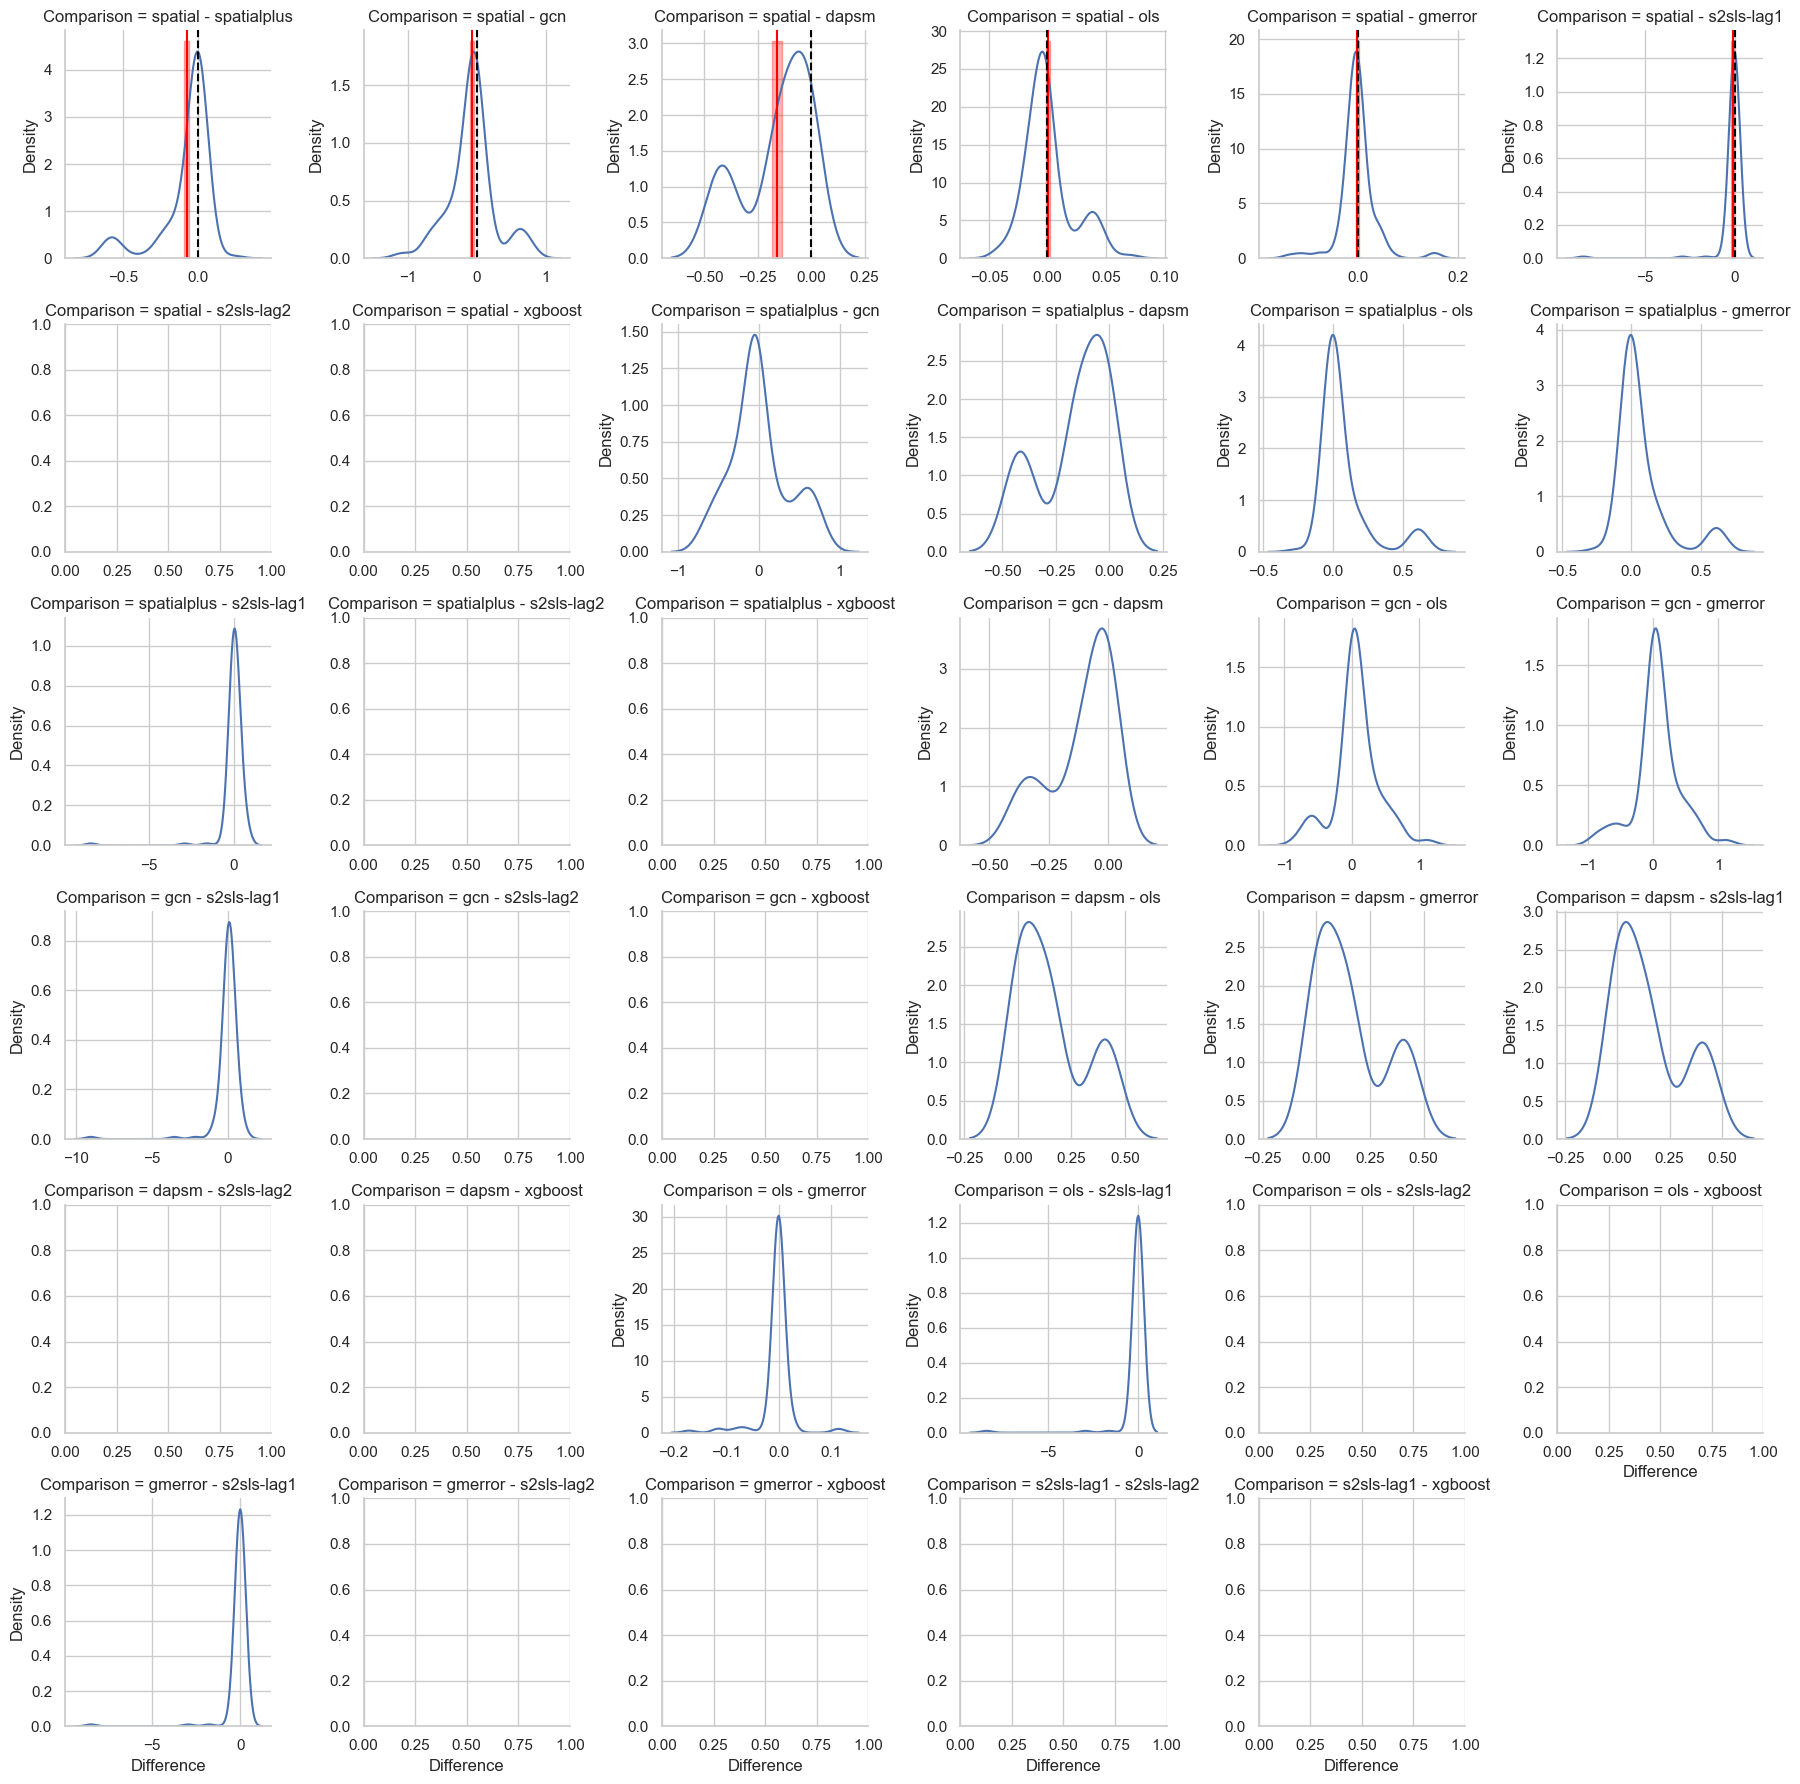

In [11]:

# Create FacetGrid
sns.set_theme(style="whitegrid")
g = sns.FacetGrid(
    pairs_data[pairs_data.Estimand == "ERF"],
    col="Comparison",
    col_wrap=6,
    sharex=False,
    sharey=False,
    height=3,
)
g.map_dataframe(sns.kdeplot, x="Difference")


# Add vertical lines and ribbons for mean and confidence interval
def add_mean_and_ci(*args, **kwargs):
    data = kwargs.pop("data")
    ax = plt.gca()
    x = data.Difference.values
    mean = np.nanmean(x)
    ci = np.nanstd(x) / np.sqrt(len(x[~np.isnan(x)]))

    ax.axvline(mean, color="red", linestyle="-", label="Mean")
    ax.fill_betweenx(
        [0, ax.get_ylim()[1]],
        mean - ci,
        mean + ci,
        alpha=0.3,
        color="red",
        label="95% CI",
    )
    ax.axvline(0.0, color="black", linestyle="--", label="Zero")


g.map_dataframe(add_mean_and_ci, x="Difference")

for ax in g.axes.flat:
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(ax.get_title().replace("Comparison = ", ""))

# Create a global legend
handles, labels = ax.get_legend_handles_labels()
g.fig.legend(handles, labels, loc="upper center", ncol=3, fontsize=12)

# Adjust subplot to fit global legend on top
g.fig.subplots_adjust(top=0.95, wspace=0.1)

## Formal Statistical Analysis

An installation of R and the packages `multcomp` and `lme4` is needed for the following formal test.

In [11]:
%load_ext rpy2.ipython

In [12]:
%%R -i analysis_data
library(lme4)
library(multcomp)

df = analysis_data
df$algo <- factor(df$algo, levels=c("ols", "spatial", "spatial+", "gcnn", "dapsm", "gmerror", "s2sls-lag1", "s2sls-lag2", "xgboost"))

model <- lmer(erf ~ algo + (1|env:dataset_id), data = df)
print(summary(glht(model, linfct = mcp(algo = "Tukey"))))

/Users/mag7273/mambaforge/envs/benchmarks/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "confounding". Fall back to string conversion. The error is: <class 'dict'>
  warnings.warn('Error while trying to convert '



	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = erf ~ algo + (1 | env:dataset_id), data = df)

Linear Hypotheses:
                             Estimate Std. Error z value Pr(>|z|)
spatial - ols == 0          0.0006585  0.0460955   0.014    1.000
spatial+ - ols == 0         0.0731268  0.0460955   1.586    0.685
gcnn - ols == 0             0.0695546  0.0460955   1.509    0.734
dapsm - ols == 0            0.1425228  0.0655814   2.173    0.304
gmerror - ols == 0          0.0030330  0.0460955   0.066    1.000
s2sls-lag1 - ols == 0       0.1130232  0.0460955   2.452    0.173
spatial+ - spatial == 0     0.0724683  0.0460955   1.572    0.695
gcnn - spatial == 0         0.0688961  0.0460955   1.495    0.743
dapsm - spatial == 0        0.1418643  0.0655814   2.163    0.310
gmerror - spatial == 0      0.0023745  0.0460955   0.052    1.000
s2sls-lag1 - spatial == 0   0.1123647  0.0460955   2.438    0.179
gcnn - spatial+ == 0

 要求されたパッケージ Matrix をロード中です 
 要求されたパッケージ mvtnorm をロード中です 
 要求されたパッケージ survival をロード中です 
 要求されたパッケージ TH.data をロード中です 
 要求されたパッケージ MASS をロード中です 

 次のパッケージを付け加えます: ‘TH.data’ 

 以下のオブジェクトは ‘package:MASS’ からマスクされています:

    geyser

 追加情報:  警告メッセージ: 
 RET$pfunction("adjusted", ...) で:  Completion with error > abseps


In [13]:
%%R 
model <- lmer(ite ~  + algo + (1|env:dataset_id), data = df)
print(summary(model))
print(summary(glht(model, linfct = mcp(algo = "Tukey"))))

Linear mixed model fit by REML ['lmerMod']
Formula: ite ~ +algo + (1 | env:dataset_id)
   Data: df

REML criterion at convergence: 924.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.2601 -0.2750 -0.0701  0.0627 20.6485 

Random effects:
 Groups         Name        Variance Std.Dev.
 env:dataset_id (Intercept) 0.07855  0.2803  
 Residual                   0.14500  0.3808  
Number of obs: 788, groups:  env:dataset_id, 124

Fixed effects:
               Estimate Std. Error t value
(Intercept)    0.342472   0.042459   8.066
algospatial    0.001543   0.048360   0.032
algospatial+   0.055706   0.048360   1.152
algogcnn       0.145099   0.048360   3.000
algodapsm      0.162730   0.068816   2.365
algogmerror    0.003165   0.048360   0.065
algos2sls-lag1 0.118542   0.048360   2.451

Correlation of Fixed Effects:
            (Intr) algspt algsp+ alggcn algdps alggmr
algospatial -0.569                                   
algospatil+ -0.569  0.500                            
algo

In [14]:
%%R 
model <- lm(erf ~ confounding_erf, data = df)
print(summary(model))

model <- lm(ite ~ confounding_ite, data = df)
print(summary(model))

model <- lm(erf ~ confounding_importance, data = df)
print(summary(model))

model <- lm(ite ~ confounding_importance, data = df)
print(summary(model))


Call:
lm(formula = erf ~ confounding_erf, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.2991 -0.1959 -0.1526  0.0692  9.0135 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.22673    0.02159   10.50   <2e-16 ***
confounding_erf  0.40882    0.23627    1.73    0.084 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4451 on 786 degrees of freedom
Multiple R-squared:  0.003795,	Adjusted R-squared:  0.002527 
F-statistic: 2.994 on 1 and 786 DF,  p-value: 0.08397


Call:
lm(formula = ite ~ confounding_ite, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.3570 -0.2528 -0.1145  0.1253  9.3795 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.30986    0.03742   8.280 5.28e-16 ***
confounding_ite  0.44641    0.17821   2.505   0.0124 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard err

In [15]:
%%R 
model <- lmer(erf ~ algo + algo * smoothness  + (1 | env), data = df)
print(summary(model))

model <- lmer(ite ~ algo + algo * smoothness  + (1 | env), data = df)
print(summary(model))

Linear mixed model fit by REML ['lmerMod']
Formula: erf ~ algo + algo * smoothness + (1 | env)
   Data: df

REML criterion at convergence: 694.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.3306 -0.2164 -0.0804  0.1074 23.0260 

Random effects:
 Groups   Name        Variance Std.Dev.
 env      (Intercept) 0.07276  0.2697  
 Residual             0.12889  0.3590  
Number of obs: 788, groups:  env, 11

Fixed effects:
                           Estimate Std. Error t value
(Intercept)                0.213296   0.107852   1.978
algospatial               -0.001646   0.099889  -0.016
algospatial+               0.055976   0.099889   0.560
algogcnn                  -0.022460   0.099889  -0.225
algodapsm                  0.209373   0.141361   1.481
algogmerror               -0.001452   0.099889  -0.015
algos2sls-lag1             0.086556   0.099889   0.867
smoothness                -0.022089   0.123981  -0.178
algospatial:smoothness     0.004536   0.174900   0.026
algospatial+:


Correlation matrix not shown by default, as p = 14 > 12.
Use print(summary(model), correlation=TRUE)  or
    vcov(summary(model))        if you need it


Correlation matrix not shown by default, as p = 14 > 12.
Use print(summary(model), correlation=TRUE)  or
    vcov(summary(model))        if you need it

